# Analyzing Smillie et al. (2019) with tree aggregated DA testing

In [3]:
# Setup
import numpy as np
import pandas as pd
import re
import toytree as tt
from tasccoda import tree_utils as util
from tasccoda import tree_ana as ana
from tasccoda import tree_results as tr
from tasccoda import tree_agg_model_sslasso as mod
import anndata as ad
from sccoda.util import comp_ana as ana2
from sccoda.model import other_models as om
import toyplot
import toyplot.locator
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import toyplot.svg
import os

import importlib

/Users/johannes.ostner/opt/anaconda3/envs/scCODA_3/lib/python3.8/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


## Data setup

Read data

In [3]:
data_path = '../../../tascCODA_data/applications/smillie_UC/SCP259/metadata/'
meta = pd.read_csv(data_path + 'meta_processed.csv')
meta["Cluster"] = [str.replace(x, " ", "") for x in meta["Cluster"]]
meta

,NAME,Subject,Sample,Location,Replicate,Health,Cluster,nGene,nUMI,Major_l1,Major_l2,Major_l3,Major_l4
0,N10.EpiA.AAACATACAACCAC,N10,EpiA,Epi,A,Healthy,EnterocyteProgenitors,425,968,Epithelial,Epithelial,Absorptive,Immature cells
1,N10.EpiA.AAACATACAGGCGA,N10,EpiA,Epi,A,Healthy,CyclingTA,1695,7273,Epithelial,Epithelial,Cycling TA3,Cycling TA4
2,N10.EpiA.AAACATACCACTAG,N10,EpiA,Epi,A,Healthy,ImmatureGoblet,391,1190,Epithelial,Epithelial,Secretory,Progenitor cells
3,N10.EpiA.AAACATACCCTTTA,N10,EpiA,Epi,A,Healthy,SecretoryTA,1327,5620,Epithelial,Epithelial,Secretory,Progenitor cells
4,N10.EpiA.AAACATACTGCAAC,N10,EpiA,Epi,A,Healthy,ImmatureEnterocytes2,1383,4676,Epithelial,Epithelial,Absorptive,Immature cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...
365487,N9.LPB.TTTATCCTAACGAA,N9,LPB,LP,B,Inflamed,Enterocytes,2768,18811,Epithelial,Epithelial,Absorptive,Absorptive Mature cells
365488,N9.LPB.TTTATCCTGTAAAG,N9,LPB,LP,B,Inflamed,Plasma,1392,27685,Immune,Lymphoid,B cells,Plasma4
365489,N9.LPB.TTTATCCTGTCGTA,N9,LPB,LP,B,Inflamed,Plasma,574,5478,Immune,Lymphoid,B cells,Plasma4
365490,N9.LPB.TTTCAGTGGCGTTA,N9,LPB,LP,B,Inflamed,Macrophages,1437,5698,Immune,Myeloid,Monocytes,Macrophages4


Get cell lineage tree info and build tree

In [4]:
vars = meta.groupby("Cluster").agg({
    "Major_l1": "first",
    "Major_l2": "first",
    "Major_l3": "first",
    "Major_l4": "first",
})
vars

,Major_l1,Major_l2,Major_l3,Major_l4
Cluster,,,,
Best4+Enterocytes,Epithelial,Epithelial,Absorptive,Absorptive Mature cells
CD4+ActivatedFos-hi,Immune,Lymphoid,T cells,CD4+ T
CD4+ActivatedFos-lo,Immune,Lymphoid,T cells,CD4+ T
CD4+Memory,Immune,Lymphoid,T cells,CD4+ T
CD4+PD1+,Immune,Lymphoid,T cells,CD4+ T
CD69+Mast,Immune,Myeloid,Mast,CD69+ Mast4
CD69-Mast,Immune,Myeloid,Mast,CD69- Mast4
CD8+IELs,Immune,Lymphoid,T cells,CD8+ T
CD8+IL17+,Immune,Lymphoid,T cells,CD8+ T


In [5]:
importlib.reload(util)
tree_levels = ["Major_l1", "Major_l2", "Major_l3", "Major_l4", "Cluster"]
newick = util.df2newick(meta.loc[:, tree_levels].reset_index(drop=True), tree_levels)

print(newick)

# Build tree
tree = tt.tree(newick=newick, tree_format=8)
tree.draw(tip_labels_align=True, node_sizes=10, node_labels='name')

(((((EnterocyteProgenitors,ImmatureEnterocytes2,ImmatureEnterocytes1)Immature cells,(TA1,TA2)TA cells,(Best4+Enterocytes,Enterocytes)Absorptive Mature cells)Absorptive,((CyclingTA)Cycling TA4)Cycling TA3,((ImmatureGoblet,SecretoryTA)Progenitor cells,(Enteroendocrine,Goblet,Tuft)Secretory Mature cells)Secretory,((Stem)Stem4)Stem3,((Mcells)M cells4)M cells3)Epithelial)Epithelial,((((CD8+IELs,CD8+LP,CyclingT,CD8+IL17+)CD8+ T,(CD4+Memory,CD4+ActivatedFos-lo,CD4+PD1+,CD4+ActivatedFos-hi,MT-hi,Tregs)CD4+ T)T cells,((CyclingB)Cycling B4,(GC)GC4,(Follicular)Follicular4,(Plasma)Plasma4)B cells,((NKs)NKs4)NKs3,((ILCs)ILCs4)ILCs3)Lymphoid,(((CD69+Mast)CD69+ Mast4,(CD69-Mast)CD69- Mast4)Mast,((Macrophages)Macrophages4,(DC2,DC1)DCs,(InflammatoryMonocytes)Inflammatory Monocytes4,(CyclingMonocytes)Cycling Monocytes4)Monocytes)Myeloid)Immune,((((WNT5B+2,WNT5B+1)WNT5B+,(WNT2B+Fos-hi,WNT2B+Fos-lo1,RSPO3+,WNT2B+Fos-lo2)WNT2B+,(InflammatoryFibroblasts)Inflammatory Fibroblast4,(Myofibroblasts)Myofibroblast

(<toyplot.canvas.Canvas at 0x7ffaa520f820>,
 <toytree.Render.ToytreeMark at 0x7ffaa52406a0>)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="365.0px" height="918.0px" viewBox="0 0 365.0 918.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t583dbd3942c34d1796c05d4f12a7c1d7"> CD4+T CD8+T Plasma4 Follicular4 GC4 CyclingB4 ILCs4 NKs4 DCs CyclingMonocytes4 InflammatoryMonocytes4 Macrophages4 CD69-Mast4 CD69+Mast4 Immaturecells AbsorptiveMaturecells TAcells SecretoryMaturecells Progenitorcells Mcells4 Stem4 CyclingTA4 WNT2B+ WNT5B+ Myofibroblast4 InflammatoryFibroblast4 EndothelialCells Glia4 Tcells Bcells ILCs3 NKs3 Monocytes Mast Absorptive Secretory Mcells3 Stem3 CyclingTA3 Fibroblasts Endothelial3 Glia3 Lymphoid Myeloid Epithelial Stromal Immune Epithelial Stromal Tregs MT-hi CD4+ActivatedFos-hi CD4+PD1+ CD4+ActivatedFos-lo CD4+Memory CD8+IL17+ CyclingT CD8+LP CD8+IELs Plasma Follicular GC CyclingB ILCs NKs DC1 DC2 CyclingMonocytes InflammatoryMonocytes Macrophages CD69-Mast CD69+Mast ImmatureEnterocytes1 ImmatureEnterocytes2 EnterocyteProgenitors Enterocytes Best4+Enterocytes TA2 TA1 Tuft Goblet Enteroendocrine SecretoryTA ImmatureGoblet Mcells Stem CyclingTA WNT2B+Fos-lo2 RSPO3+ WNT2B+Fos-lo1 WNT2B+Fos-hi WNT5B+1 WNT5B+2 Myofibroblasts InflammatoryFibroblasts Post-capillaryVenules Endothelial Microvascular Pericytes Glia

Get count matrix and metadata df

In [6]:
counts = pd.crosstab(
    [meta["Sample"], meta["Subject"], meta["Location"], meta["Health"], meta["Replicate"]],
    meta["Cluster"])
counts

Cluster                                         Best4+Enterocytes  \
Sample Subject Location Health       Replicate                      
EpiA   N10     Epi      Healthy      A                         93   
       N106    Epi      Non-inflamed A                          3   
       N11     Epi      Healthy      A                         93   
       N110    Epi      Non-inflamed A                        221   
       N12     Epi      Non-inflamed A                         18   
...                                                           ...   
LPB2   N111    LP       Inflamed     B2                         1   
       N58     LP       Inflamed     B2                         0   
       N661    LP       Inflamed     B2                         0   
LPB2a  N52     LP       Inflamed     B2a                        1   
LPB2b  N52     LP       Inflamed     B2b                        1   

Cluster                                         CD4+ActivatedFos-hi  \
Sample Subject Location Health       Replicate                        
EpiA   N10     Epi      Healthy      A                            1   
       N106    Epi      Non-inflamed A                            0   
       N11     Epi      Healthy      A                            1   
       N110    Epi      Non-inflamed A                            0   
       N12     Epi      Non-inflamed A                            0   
...                                                             ...   
LPB2   N111    LP       Inflamed     B2                         138   
       N58     LP       Inflamed     B2                           5   
       N661    LP       Inflamed     B2                          82   
LPB2a  N52     LP       Inflamed     B2a                        119   
LPB2b  N52     LP       Inflamed     B2b                        125   

Cluster                                         CD4+ActivatedFos-lo  \
Sample Subject Location Health       Replicate                        
EpiA   N10     Epi      Healthy      A                            2   
       N106    Epi      Non-inflamed A                            0   
       N11     Epi      Healthy      A                            0   
       N110    Epi      Non-inflamed A                            0   
       N12     Epi      Non-inflamed A                            0   
...                                                             ...   
LPB2   N111    LP       Inflamed     B2                          15   
       N58     LP       Inflamed     B2                           1   
       N661    LP       Inflamed     B2                          38   
LPB2a  N52     LP       Inflamed     B2a                        404   
LPB2b  N52     LP       Inflamed     B2b                        404   

Cluster                                         CD4+Memory  CD4+PD1+  \
Sample Subject Location Health       Replicate                         
EpiA   N10     Epi      Healthy      A                  11         5   
       N106    Epi      Non-inflamed A                   0         0   
       N11     Epi      Healthy      A                   8         0   
       N110    Epi      Non-inflamed A                   1         0   
       N12     Epi      Non-inflamed A                   0         0   
...                                                    ...       ...   
LPB2   N111    LP       Inflamed     B2                717        24   
       N58     LP       Inflamed     B2                  1         0   
       N661    LP       Inflamed     B2               1431         0   
LPB2a  N52     LP       Inflamed     B2a               348         0   
LPB2b  N52     LP       Inflamed     B2b               338         0   

Cluster                                         CD69+Mast  CD69-Mast  \
Sample Subject Location Health       Replicate                         
EpiA   N10     Epi      Healthy      A                  2          8   
       N106    Epi      Non-inflamed A                  2          0   
       N11     Epi      Healt

In [7]:
obs = pd.DataFrame(index=counts.index).reset_index()
obs
counts = counts.reset_index(drop=True)

Put it all together in an anndata object, separate them by location

In [8]:
data = ad.AnnData(X=counts, var=vars, obs=obs, uns={"newick": newick, "phylo_tree": tree})

/Users/johannes.ostner/opt/anaconda3/envs/scCODA_3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
data_epi = data[data.obs["Location"] == "Epi"]
print(data_epi)

data_lp = data[data.obs["Location"] == "LP"]
print(data_lp)

all_data = {"all": data, "epi": data_epi, "LP": data_lp}


View of AnnData object with n_obs × n_vars = 61 × 51
    obs: 'Sample', 'Subject', 'Location', 'Health', 'Replicate'
    var: 'Major_l1', 'Major_l2', 'Major_l3', 'Major_l4'
    uns: 'newick', 'phylo_tree'
View of AnnData object with n_obs × n_vars = 72 × 51
    obs: 'Sample', 'Subject', 'Location', 'Health', 'Replicate'
    var: 'Major_l1', 'Major_l2', 'Major_l3', 'Major_l4'
    uns: 'newick', 'phylo_tree'


In [10]:
# Split data by two conditions

data_epi_hn = data_epi[data_epi.obs["Health"].isin(["Healthy", "Non-inflamed"])]
data_epi_hi = data_epi[data_epi.obs["Health"].isin(["Healthy", "Inflamed"])]
data_epi_ni = data_epi[data_epi.obs["Health"].isin(["Non-inflamed", "Inflamed"])]

data_LP_hn = data_lp[data_lp.obs["Health"].isin(["Healthy", "Non-inflamed"])]
data_LP_hi = data_lp[data_lp.obs["Health"].isin(["Healthy", "Inflamed"])]
data_LP_ni = data_lp[data_lp.obs["Health"].isin(["Non-inflamed", "Inflamed"])]

datasets = {
    "epi_hn": data_epi_hn,
    "epi_hi": data_epi_hi,
    "epi_ni": data_epi_ni,
    "LP_hn": data_LP_hn,
    "LP_hi": data_LP_hi,
    "LP_ni": data_LP_ni,
}









## Apply Dirichlet regression and scCODA

Adjust these paths to wherever your R environment is located!

In [ ]:
r_home = "/Library/Frameworks/R.framework/Resources"
r_path = r"/Library/Frameworks/R.framework/Resources/bin"

In [ ]:
#DirReg model

results_dr = {}

for name, dat in datasets.items():
    dr_mod = om.DirichRegModel(dat, "Health")
    dr_mod.fit_model(r_home, r_path)
    df = dr_mod.var.copy()
    _, p_adj, _, _ =  sm.stats.multitest.multipletests(dr_mod.p_val, 0.05, method="fdr_bh")
    df["p_val"] = dr_mod.p_val
    df["p_adj"] = p_adj
    df["sign"] = ["***" if x < 0.001 else "**" if x < 0.01 else "*" if x < 0.05 else "" for x in p_adj]
    results_dr[name] = df

In [38]:
#scCODA model

results_sccoda = {}

for name, dat in datasets.items():
    order = [n.name for n in data.uns["phylo_tree"].treenode.traverse() if n.is_leaf()]
    order.reverse()
    order_ind = [data.var.index.tolist().index(x) for x in order]

    var2 = data.var.reindex(order)

    X2 = data.X[:, order_ind]
    sccoda_mod = ana2.CompositionalAnalysis(dat.copy(), "Health", "automatic")
    sccoda_res = sccoda_mod.sample_hmc(num_results=20000, num_burnin=5000)
    results_sccoda[name] = sccoda_res

/Users/johannes.ostner/Documents/PhD/scCODA/scCODA/sccoda/util/comp_ana.py:89: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)


Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [03:32<00:00, 94.18it/s] 


MCMC sampling finished. (265.601 sec)
Acceptance rate: 61.0%


/Users/johannes.ostner/Documents/PhD/scCODA/scCODA/sccoda/util/result_classes.py:252: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/Users/johannes.ostner/opt/anaconda3/envs/scCODA_3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/johannes.ostner/Documents/PhD/scCODA/scCODA/sccoda/util/comp_ana.py:89: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)


Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [03:17<00:00, 101.45it/s]


MCMC sampling finished. (247.680 sec)
Acceptance rate: 66.0%


/Users/johannes.ostner/Documents/PhD/scCODA/scCODA/sccoda/util/result_classes.py:252: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/Users/johannes.ostner/opt/anaconda3/envs/scCODA_3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/johannes.ostner/Documents/PhD/scCODA/scCODA/sccoda/util/comp_ana.py:89: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)


Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [03:18<00:00, 100.89it/s]


MCMC sampling finished. (247.361 sec)
Acceptance rate: 66.0%


/Users/johannes.ostner/Documents/PhD/scCODA/scCODA/sccoda/util/result_classes.py:252: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/Users/johannes.ostner/opt/anaconda3/envs/scCODA_3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Automatic reference selection! Reference cell type set to NKs
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [03:34<00:00, 93.40it/s] 


MCMC sampling finished. (268.163 sec)
Acceptance rate: 46.3%


/Users/johannes.ostner/Documents/PhD/scCODA/scCODA/sccoda/util/result_classes.py:252: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/Users/johannes.ostner/opt/anaconda3/envs/scCODA_3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Automatic reference selection! Reference cell type set to CD8+IELs
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [04:25<00:00, 75.25it/s] 


MCMC sampling finished. (318.369 sec)
Acceptance rate: 49.6%


/Users/johannes.ostner/Documents/PhD/scCODA/scCODA/sccoda/util/result_classes.py:252: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/Users/johannes.ostner/opt/anaconda3/envs/scCODA_3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Automatic reference selection! Reference cell type set to DC2
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [03:38<00:00, 91.50it/s] 


MCMC sampling finished. (273.043 sec)
Acceptance rate: 59.0%


/Users/johannes.ostner/Documents/PhD/scCODA/scCODA/sccoda/util/result_classes.py:252: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/Users/johannes.ostner/opt/anaconda3/envs/scCODA_3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [39]:
for res in results_sccoda.values():
    res.effect_df.index = res.effect_df.index.droplevel(0)

In [232]:
res_path = '../../../tascCODA_data/applications/smillie_UC'

for name, data in results_dr.items():
    data.to_csv(res_path + f"/results_dr/{name}")

for name, data in results_sccoda.items():
    data.to_csv(res_path + f"/results_sccoda/{name}")

## tascCODA analysis

Plotting functions:
- Tree plot with bars on the side
- Boxplots with indicators for all three models

In [116]:
def smillie_tree_plot(result, data, title, sccoda_data, save=False, plot_path=""):
    # Edge colors in tree by major lineage
    edge_color_dict = {
        "Immune": "purple",
        "Stromal": "orange",
        "Epithelial": "green"
    }

    edge_colors = {}
    markers = []
    for x, y in edge_color_dict.items():
        m = toyplot.marker.create(shape="o", size=8, mstyle={"fill": y})
        markers.append((x, m))

    var = data.var.reset_index().applymap(lambda x: re.sub(" ", "", x))
    var_levels = var.columns

    for n in result.node_df.index.get_level_values("Node"):
        done = False
        for v in var_levels:
            if n in var.loc[:, v].values:
                edge_colors[n] = edge_color_dict[var.loc[var[v] == n, "Major_l1"].values[0]]
                done = True

        if done == False or n in var.loc[:, "Major_l1"].values:
                edge_colors[n] = "black"

    # canvas bound units
    tree2 = util.collapse_singularities(data.uns["phylo_tree"])
    ct_max = len(result.effect_df)
    ymax = len(result.node_df)
    ct_width = 600/ct_max
    y_upper = ct_width * (ymax+1)

    # draw tree
    canvas = toyplot.Canvas(width=850, height=1000)
    ax0 = canvas.cartesian(bounds=(200, 620, 50, 650), padding=0, ymin=0, ymax=ct_max, xmin=-5, xmax=2.5)
    ax0.y.show = False
    ax0.x.show = False

    result.draw_tree(
        axes=ax0,
        tree=data.uns["phylo_tree"],
        #layout='c',
        edge_type='p',
        # node_style={"fill": "blue"},
        tip_labels="name",
        tip_labels_align=True,
        tip_labels_style={"font-size": "12px", "-toyplot-anchor-shift":"15px"},
        edge_colors=list(edge_colors.values()),
        edge_style={"stroke-width": 2}
        )

    # plot title
    ax1 = canvas.cartesian(bounds=(0, 800, 50, 100), padding=0, label=title)
    ax1.x.show=False
    ax1.y.show=False

    # effect bar sizes tascCODA
    e_ = result.node_df.copy()
    e_.index = e_.index.droplevel(0)
    tip_names = [n for n in tree2.get_tip_labels()]
    node_names = [n for n in tree2.get_node_values("name") if n != ""]
    effs = [e_.loc[n, "Final Parameter"] for n in tip_names]
    effs2 = [e_.loc[n, "Final Parameter"] for n in node_names]
    effs = effs2 + effs
    node_names.reverse()

    # effect bar sizes scCODA
    e_scc = sccoda_data.effect_df.copy()
    e_scc.index = [re.sub(" ", "", x) for x in e_scc.index]
    effs_sccoda = [0 for x in range(len(effs2))] + [e_scc.loc[n, "Final Parameter"] for n in tip_names]

    ref = result.model_specs["reference"]

    # draw bars
    xmin = np.min([np.min(result.effect_df["Effect"]), np.min(sccoda_data.effect_df["Final Parameter"]), -0.5]),
    xmax = np.max([np.max(result.effect_df["Effect"]), np.max(sccoda_data.effect_df["Final Parameter"]), 0.5])
    ax2 = canvas.cartesian(
        bounds=(620, 800, 50, y_upper + 50),
        padding=0,
        ymin=0,
        ymax=ymax+1,
        xmin=xmin,
        xmax=xmax
    )
    ax2.y.show=False
    ax2.x.ticks.show=True
    ax2.x.label.text = "Effect size"

    ax2.bars(
        np.arange(ymax) + 1.05,
        np.arange(ymax) + 1.45,
        effs,
        along='y',
        color="blue",
    )
    ax2.bars(
        np.arange(ymax) +0.95,
        np.arange(ymax) +0.55,
        effs_sccoda,
        along='y',
        color="red",
    )
    ax2.vlines(x=0)

    # node labels below tree
    ax3 = canvas.cartesian(
        bounds=(200, 620, 650, y_upper + 50),
        padding=0,
        xmin=-5,
        xmax=2.5,
        ymin=0,
        ymax=len(effs2)+1
    )
    ax3.x.show=False
    ax3.y.show=False
    ax3.text(0, len(effs2)+1, text="<br/>".join(node_names),
             style={
                 "font-size":"12px",
                 "fill": "black",
                 "text-anchor":"start",
                 "-toyplot-anchor-shift":"15px",
                 "-toyplot-vertical-align":"top",
                 "line-height": "12px",
                 "baseline-shift":"-4px"
             }
             )

    # shaded rows
    for i in range(ymax):
        if i-len(effs2) == ref:
            ax2.rectangle(ref+len(effs2)+0.5, ref+len(effs2)+1.5, xmin, xmax, color="green", opacity=0.3, along="y")
            ax0.rectangle(0.2, 2.5, ref-0.5, ref+0.5, color="green", opacity=0.3)
        elif i%2 == 0:
            ax2.rectangle(i+0.5, i+1.5, xmin, xmax, color="grey", opacity=0.3, along="y")
            if i > len(effs2):
                ax0.rectangle(0.2, 2.5, i-len(effs2)-0.5, i-len(effs2)+0.5, color="grey", opacity=0.3)
            else:
                ax3.rectangle(0.2, 2.5, i+0.5, i+1.5, color="grey", opacity=0.3)

    # legend
    canvas.legend(markers,
        bounds=(50, 100, 300, 380),
        label="Major lineage"
    )
    emax = np.max(np.abs(result.node_df["Final Parameter"]))
    markers2 = [
        (f"{emax}",toyplot.marker.create(shape="o", size=20, mstyle={"fill": "black"})),
        (f"{-1*emax}",toyplot.marker.create(shape="o", size=20, mstyle={"fill": "white"}))
    ]
    canvas.legend(markers2,
        bounds=(50, 100, 420, 500),
        label=f"Effects"
    )
    markers3 = [
        (f"tascCODA",toyplot.marker.create(shape="s", size=8, mstyle={"fill": "blue"})),
        (f"scCODA",toyplot.marker.create(shape="s", size=8, mstyle={"fill": "red"}))
    ]
    canvas.legend(markers3,
        bounds=(50, 100, 540, 620),
        label=f"Models"
    )

    # save plot
    if save:
        toyplot.svg.render(canvas, plot_path)

def smillie_boxplot(plot_df, results_tree, results_sccoda, results_dr, data_all, save=False, plot_path="", group="epi"):
    vc = data_all.var["ct_group"].value_counts()

    fig = plt.figure(constrained_layout=False, figsize=(12, 10))
    gs = fig.add_gridspec(2,2, width_ratios=[vc[0], vc[1]])
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, :])
    ax = [ax0, ax1, ax2]
    for i in range(3):
        sns.boxplot(x="Cell type", y="Proportion", hue="Health", data=plot_df[plot_df["ct_group"] == i], fliersize=1,
                        palette="Blues", ax=ax[i])
        sns.despine()
        h, l = ax[i].get_legend_handles_labels()
        ax[i].legend([], [], frameon=False)
        ax[i].tick_params(axis='x', rotation=90)

    ax1.legend(h, l, bbox_to_anchor=(1.05, -0.3),
        loc=2,
        borderaxespad=0., title="Health", frameon=False)

    ax2.legend(
        [mpatches.Patch(color='blue'), mpatches.Patch(color='red'), mpatches.Patch(color='green')],
        ["tascCODA", "scCODA", "DirichletReg"],
        bbox_to_anchor=(1.04, 1),
        loc=2,
        borderaxespad=0., title="Model", frameon=False)

    if group =="epi":
        title="Epithelium"
        keys = ["epi_hn", "epi_ni", "epi_hi"]
        ys = {0: 0.7, 1: 0.4, 2: 0.15}
        ys_2 = {0: 0.75, 1: 0.43, 2: 0.162}
        ys_3= {0: 0.8, 1: 0.46, 2: 0.174}
    elif group=="LP":
        title="Lamina Propria"
        keys = ["LP_hn", "LP_ni", "LP_hi"]
        ys = {0: 0.9, 1: 0.4, 2: 0.15}
        ys_2 = {0: 0.95, 1: 0.43, 2: 0.162}
        ys_3= {0: 1, 1: 0.46, 2: 0.174}
    else:
        raise NameError("invalid group!")

    fig.suptitle(title)

    x_offset = {0: [-0.3, -0.05], 1: [0.05, 0.3], 2: [-0.3, 0.3]}
    for it in range(3):
        for ct in results_dr[keys[it]].index:
            group = data_all.var.loc[ct, "ct_group"]
            x_val = np.where(data_all.var[data_all.var["ct_group"] == group].index == ct)[0]

            text = results_dr[keys[it]].loc[ct, "sign"]
            if text != "":
                if it == 2:
                    y_s = ys[group] + 0.005*(3-group)
                else:
                    y_s = ys[group]
                ax[group].hlines(y=y_s, xmin=x_val + x_offset[it][0], xmax=x_val + x_offset[it][1], color="green")

            effect_scc = results_sccoda[keys[it]].effect_df.loc[ct, "Final Parameter"]
            if effect_scc != 0:
                if it == 2:
                    y_s = ys_2[group] + 0.005*(3-group)
                else:
                    y_s = ys_2[group]
                ax[group].hlines(y=y_s, xmin=x_val + x_offset[it][0], xmax=x_val + x_offset[it][1], color="red")

            eff = results_tree[keys[it]].effect_df.copy()
            eff.index = eff.index.droplevel(0)
            effect_tree = eff.loc[ct, "Effect"]
            if effect_tree != 0:
                if it == 2:
                    y_s = ys_3[group] + 0.005*(3-group)
                else:
                    y_s = ys_3[group]
                ax[group].hlines(y=y_s, xmin=x_val + x_offset[it][0], xmax=x_val + x_offset[it][1], color="blue")

    plt.tight_layout()

    if save:
        plt.savefig(plot_path, bbox_inches="tight", format="svg")

    plt.show()

Function for running tascCODA with parameters lambda_0, lambda_1, phi on all datasets.
Plots tree plots and boxplots.

In [12]:

def run_tree_agg(lambda_0, lambda_1, phi, datasets, all_data, chain_length=2000, plot=True, result_path="./results_smillie/", plot_path="./plots_smillie/"):
    results = {}

    for name, dat in datasets.items():
        print("")
        print(name)
        print("")

        tree_mod= ana.CompositionalAnalysisTree(
            dat.copy(),
            reference_cell_type="automatic",
            formula="Health",
            reg="scaled_3",
            pen_args={"lambda_0": lambda_0, "phi": phi, "lambda_1": lambda_1},
            model="new"
        )

        tree_res = tree_mod.sample_hmc_da(num_results=chain_length, num_burnin=int(chain_length/4))
        results[name] = tree_res

    run_name = f"tree_agg_l0_{lambda_0}_l1_{lambda_1}_phi_{phi}_n_{chain_length}"
    new_path = f'../../../tascCODA_data/applications/smillie_UC/{run_name}'

    for name, res in results.items():
        res.effect_df.to_csv(new_path + f"/{name}_effects")
        res.node_df.to_csv(new_path + f"/{name}_nodes")

    if plot:
        results_dr = {}
        for name in os.listdir("../../../tascCODA_data/applications/smillie_UC/results_dr"):
            results_dr[name] = pd.read_csv("../../../tascCODA_data/applications/smillie_UC/results_dr" + f"/{name}")

        results_sccoda = {}
        for name in os.listdir("../../../tascCODA_data/applications/smillie_UC/results_sccoda"):
            results_sccoda[name] = pd.read_csv("../../../tascCODA_data/applications/smillie_UC/results_sccoda" + f"/{name}")

        plot_dir = plot_path + run_name + "/"
        try:
            os.mkdir(plot_dir)
        except FileExistsError:
            pass

        titles = {
            "epi_hn": "Epithelium; Healthy vs. Non-inflamed",
            "epi_hi": "Epithelium; Healthy vs. Inflamed",
            "epi_ni": "Epithelium; Non-inflamed vs. Inflamed",
            "LP_hn": "Lamina Propria; Healthy vs. Non-inflamed",
            "LP_hi": "Lamina Propria; Healthy vs. Inflamed",
            "LP_ni": "Lamina Propria; Non-inflamed vs. Inflamed",
        }

        for name, res in results.items():
            smillie_tree_plot(res, datasets[name], titles[name], results_sccoda[name], save=True, plot_path=plot_dir+f"tree_{name}.svg")

        data_rel = all_data["all"].X / np.sum(all_data["all"].X, axis=1, keepdims=True)

        data_rel_epi = all_data["epi"].X / np.sum(all_data["epi"].X, axis=1, keepdims=True)
        ct_max = np.max(data_rel, axis=0)
        all_data["all"].var["max_rel_abun"] = ct_max
        all_data["all"].var["ct_group"] = [0 if x > 0.4 else 1 if x > 0.15 else 2 for x in ct_max]
        count_df_epi = pd.DataFrame(data_rel_epi, columns=all_data["epi"].var.index, index=all_data["epi"].obs.index).merge(all_data["epi"].obs["Health"], left_index=True, right_index=True)
        plot_df_epi = pd.melt(count_df_epi, id_vars="Health", var_name="Cell type", value_name="Proportion").merge(all_data["all"].var["ct_group"], left_on="Cell type", right_index=True)

        data_rel_LP = all_data["LP"].X / np.sum(all_data["LP"].X, axis=1, keepdims=True)
        value_name = "Proportion"
        count_df_LP = pd.DataFrame(data_rel_LP, columns=all_data["LP"].var.index, index=all_data["LP"].obs.index).merge(all_data["LP"].obs["Health"], left_index=True, right_index=True)
        plot_df_LP = pd.melt(count_df_LP, id_vars="Health", var_name="Cell type", value_name=value_name).merge(data.var["ct_group"], left_on="Cell type", right_index=True)

        smillie_boxplot(plot_df_epi, results, results_sccoda, results_dr, all_data["all"], group="epi", save=True, plot_path=plot_dir+"boxplots_epi.svg")
        smillie_boxplot(plot_df_LP, results, results_sccoda, results_dr, all_data["all"], group="LP", save=True, plot_path=plot_dir+"boxplots_LP.svg")

    return results

Apply tascCODA with different parameter settings (this takes some time!):


epi_hn

Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_ana.py:110: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)
/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:04<00:00, 108.46it/s]


MCMC sampling finished. (229.317 sec)
Acceptance rate: 87.0%

epi_hi

Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_ana.py:110: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)
/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:53<00:00, 115.00it/s]


MCMC sampling finished. (216.915 sec)
Acceptance rate: 85.2%

epi_ni

Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_ana.py:110: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)
/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:52<00:00, 115.72it/s]


MCMC sampling finished. (215.788 sec)
Acceptance rate: 89.8%

LP_hn

Automatic reference selection! Reference cell type set to NKs
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:06<00:00, 107.17it/s]


MCMC sampling finished. (232.954 sec)
Acceptance rate: 84.6%

LP_hi

Automatic reference selection! Reference cell type set to CD8+IELs
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:11<00:00, 104.66it/s]


MCMC sampling finished. (236.321 sec)
Acceptance rate: 86.5%

LP_ni

Automatic reference selection! Reference cell type set to DC2
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:08<00:00, 106.30it/s]


MCMC sampling finished. (232.591 sec)
Acceptance rate: 86.3%


/Users/johannes.ostner/opt/anaconda3/envs/scCODA_3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


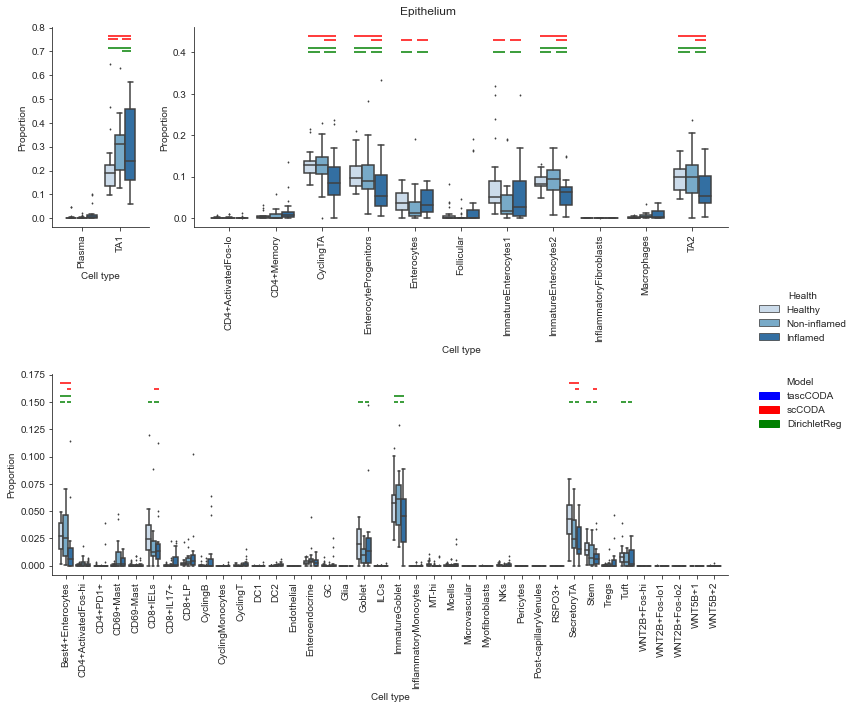

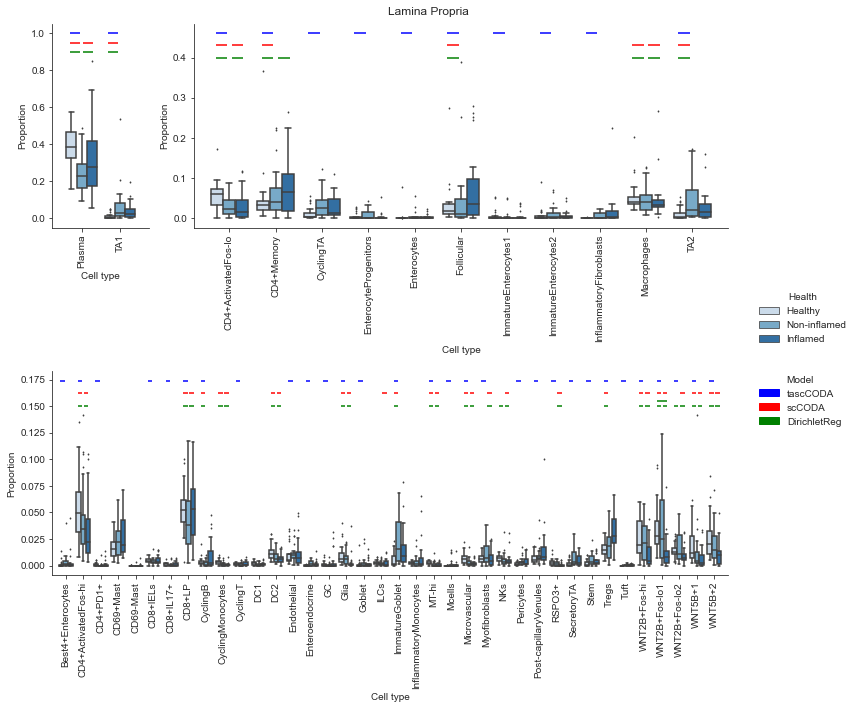

In [16]:
importlib.reload(ana)
importlib.reload(tr)
importlib.reload(util)
importlib.reload(mod)

lambda_0 = 50
phi = -3
lambda_1 = 5

results = run_tree_agg(lambda_0, lambda_1, phi, datasets, all_data, 20000, plot=True)



epi_hn

Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_ana.py:110: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)
/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:01<00:00, 110.46it/s]


MCMC sampling finished. (226.611 sec)
Acceptance rate: 87.3%

epi_hi

Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_ana.py:110: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)
/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:51<00:00, 116.91it/s]


MCMC sampling finished. (216.592 sec)
Acceptance rate: 83.9%

epi_ni

Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_ana.py:110: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)
/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:54<00:00, 114.33it/s]


MCMC sampling finished. (216.837 sec)
Acceptance rate: 86.8%

LP_hn

Automatic reference selection! Reference cell type set to NKs
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:06<00:00, 107.12it/s]


MCMC sampling finished. (230.388 sec)
Acceptance rate: 89.6%

LP_hi

Automatic reference selection! Reference cell type set to CD8+IELs
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:04<00:00, 108.65it/s]


MCMC sampling finished. (229.070 sec)
Acceptance rate: 88.7%

LP_ni

Automatic reference selection! Reference cell type set to DC2
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:06<00:00, 107.11it/s]


MCMC sampling finished. (232.768 sec)
Acceptance rate: 87.5%


/Users/johannes.ostner/opt/anaconda3/envs/scCODA_3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


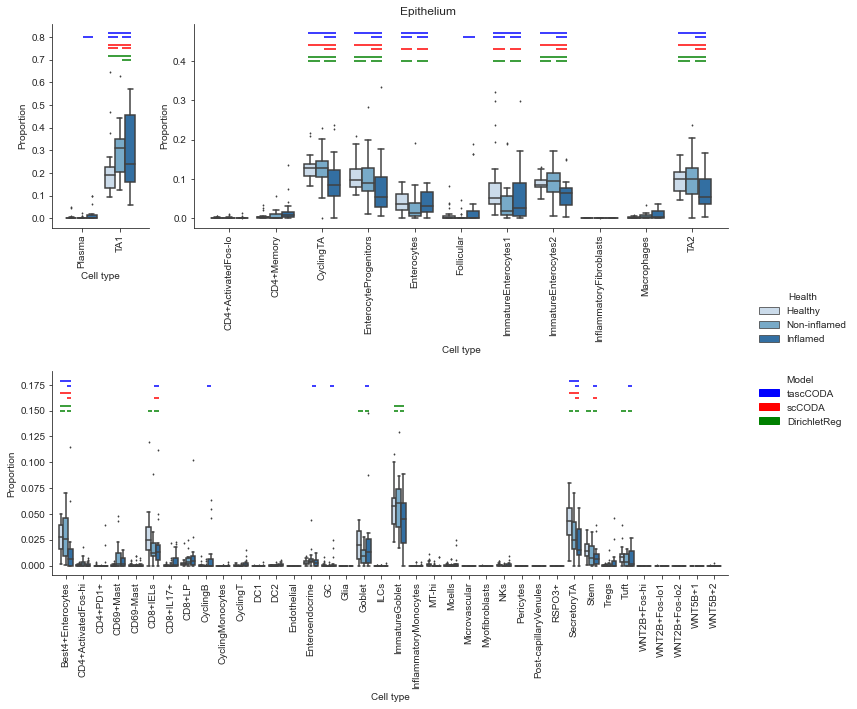

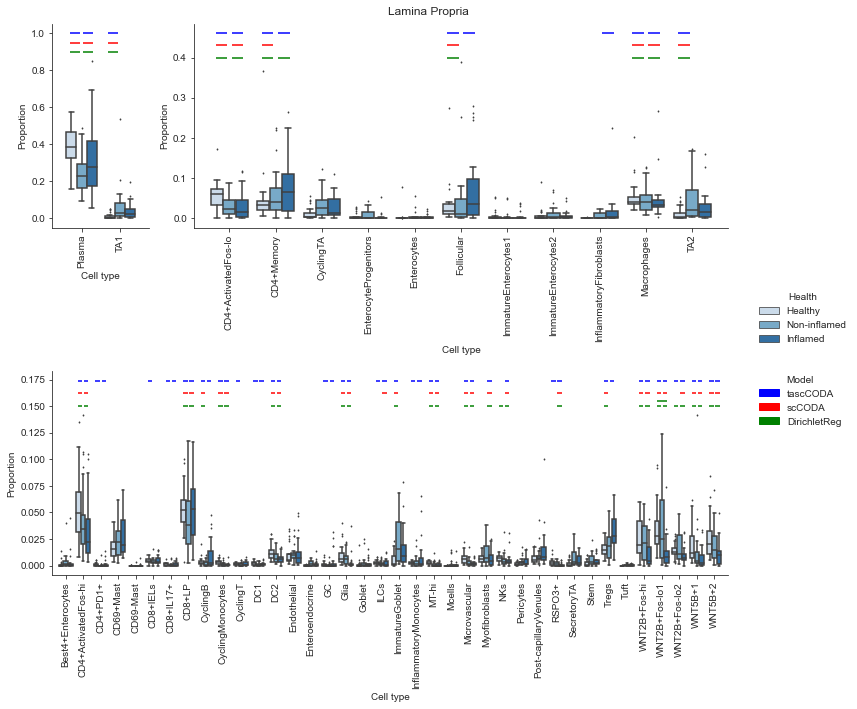

In [17]:
lambda_0 = 50
phi = 5
lambda_1 = 5

results = run_tree_agg(lambda_0, lambda_1, phi, datasets, all_data, 20000, plot=True)



epi_hn

Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_ana.py:110: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)
/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:02<00:00, 109.65it/s]


MCMC sampling finished. (228.120 sec)
Acceptance rate: 87.9%

epi_hi

Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_ana.py:110: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)
/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:47<00:00, 119.48it/s]


MCMC sampling finished. (213.210 sec)
Acceptance rate: 85.4%

epi_ni

Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_ana.py:110: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)
/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:46<00:00, 119.86it/s]


MCMC sampling finished. (207.397 sec)
Acceptance rate: 89.3%

LP_hn

Automatic reference selection! Reference cell type set to NKs
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:02<00:00, 109.85it/s]


MCMC sampling finished. (225.881 sec)
Acceptance rate: 83.2%

LP_hi

Automatic reference selection! Reference cell type set to CD8+IELs
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:57<00:00, 112.51it/s]


MCMC sampling finished. (221.693 sec)
Acceptance rate: 91.0%

LP_ni

Automatic reference selection! Reference cell type set to DC2
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:00<00:00, 110.92it/s]


MCMC sampling finished. (223.975 sec)
Acceptance rate: 86.8%


/Users/johannes.ostner/opt/anaconda3/envs/scCODA_3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


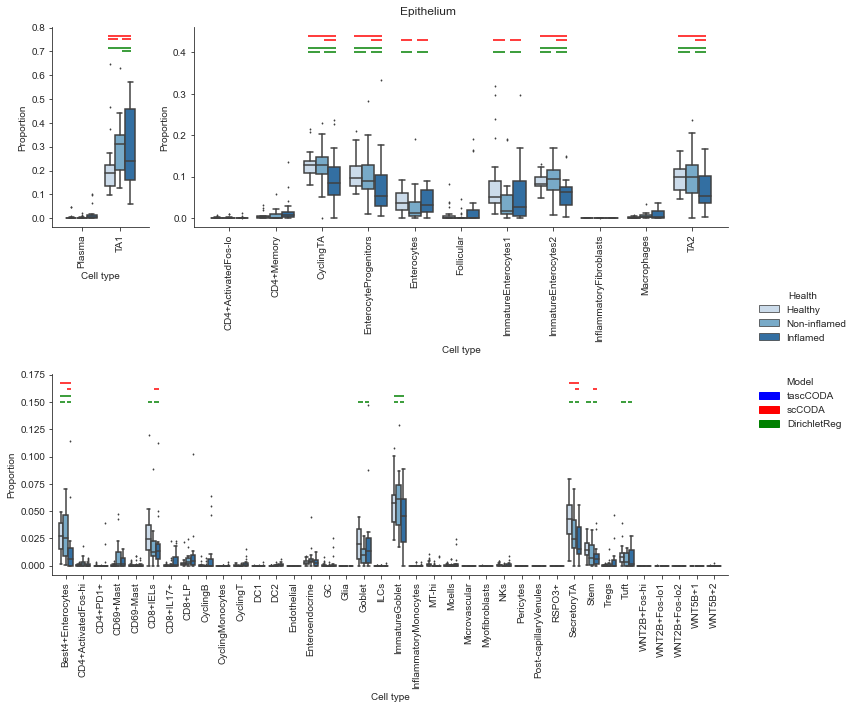

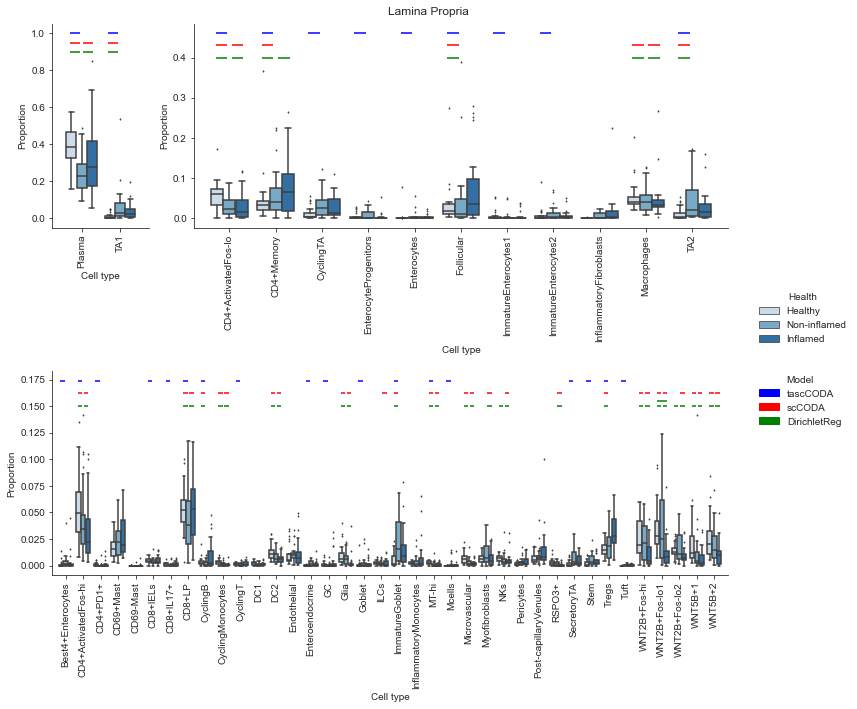

In [18]:
lambda_0 = 50
phi = -5
lambda_1 = 5

results = run_tree_agg(lambda_0, lambda_1, phi, datasets, all_data, 20000, plot=True)


epi_hn

Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_ana.py:110: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)
/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:56<00:00, 113.09it/s]


MCMC sampling finished. (221.350 sec)
Acceptance rate: 85.7%

epi_hi

Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_ana.py:110: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)
/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:49<00:00, 117.70it/s]


MCMC sampling finished. (212.529 sec)
Acceptance rate: 84.1%

epi_ni

Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_ana.py:110: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)
/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:15<00:00, 102.25it/s]


MCMC sampling finished. (242.037 sec)
Acceptance rate: 88.2%

LP_hn

Automatic reference selection! Reference cell type set to NKs
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:34<00:00, 93.45it/s] 


MCMC sampling finished. (263.024 sec)
Acceptance rate: 82.6%

LP_hi

Automatic reference selection! Reference cell type set to CD8+IELs
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:46<00:00, 88.35it/s] 


MCMC sampling finished. (280.554 sec)
Acceptance rate: 82.5%

LP_ni

Automatic reference selection! Reference cell type set to DC2
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:26<00:00, 96.66it/s] 


MCMC sampling finished. (257.443 sec)
Acceptance rate: 88.3%


/Users/johannes.ostner/opt/anaconda3/envs/scCODA_3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


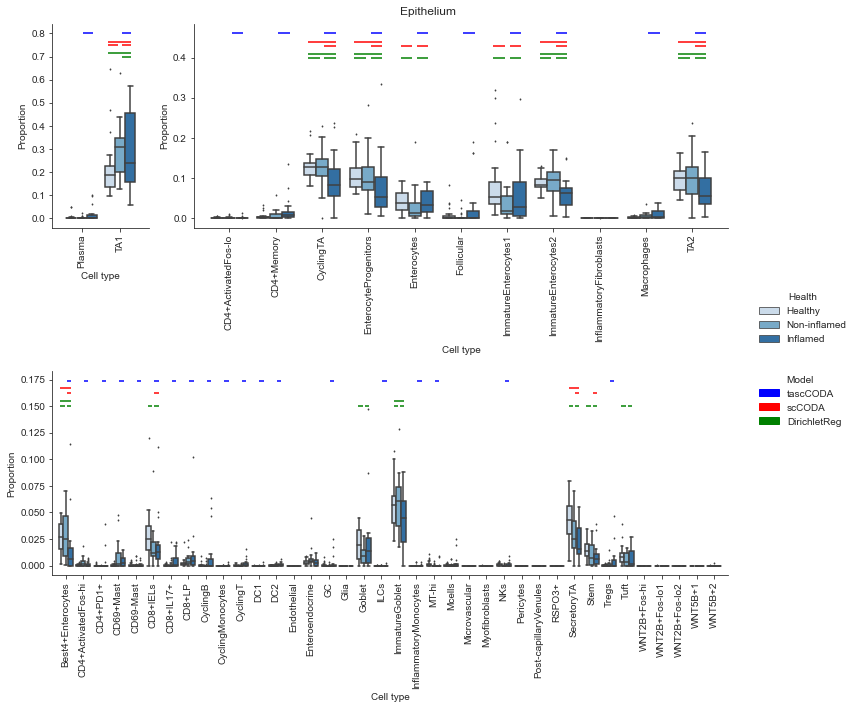

KeyboardInterrupt: 

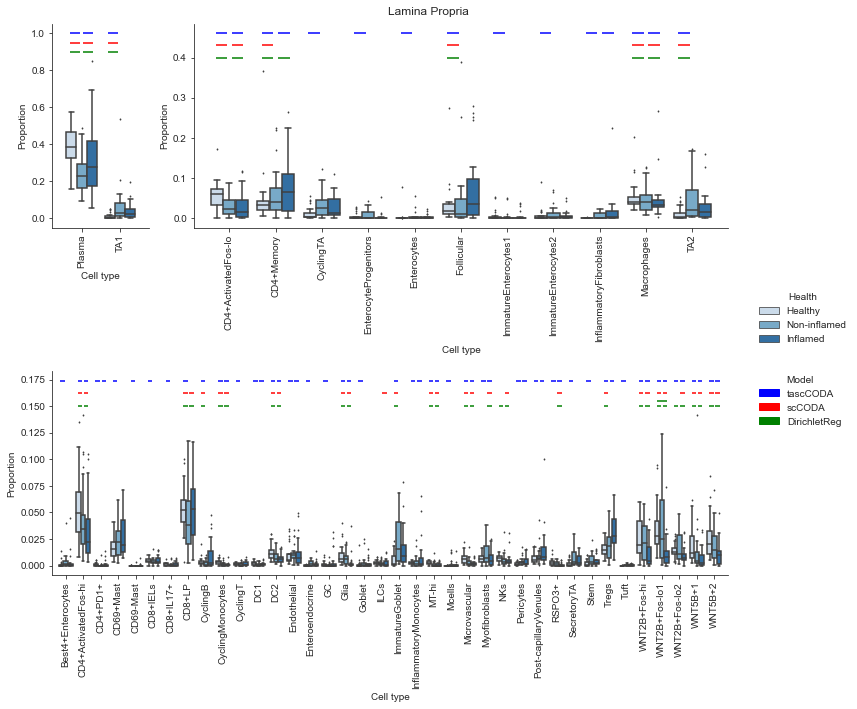

In [19]:
lambda_0 = 50
phi = 0
lambda_1 = 5

results = run_tree_agg(lambda_0, lambda_1, phi, datasets, all_data, 20000, plot=True)


epi_hn

Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_ana.py:110: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)
/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:45<00:00, 88.69it/s] 


MCMC sampling finished. (275.885 sec)
Acceptance rate: 87.6%

epi_hi

Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_ana.py:110: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)
/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:04<00:00, 108.17it/s]


MCMC sampling finished. (233.031 sec)
Acceptance rate: 84.3%

epi_ni

Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_ana.py:110: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)
/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:39<00:00, 125.45it/s]


MCMC sampling finished. (207.102 sec)
Acceptance rate: 87.9%

LP_hn

Automatic reference selection! Reference cell type set to NKs
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:17<00:00, 101.16it/s]


MCMC sampling finished. (247.966 sec)
Acceptance rate: 83.4%

LP_hi

Automatic reference selection! Reference cell type set to CD8+IELs
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:17<00:00, 101.19it/s]


MCMC sampling finished. (246.263 sec)
Acceptance rate: 87.6%

LP_ni

Automatic reference selection! Reference cell type set to DC2
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:14<00:00, 102.59it/s]


MCMC sampling finished. (246.676 sec)
Acceptance rate: 87.9%


/Users/johannes.ostner/opt/anaconda3/envs/scCODA_3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


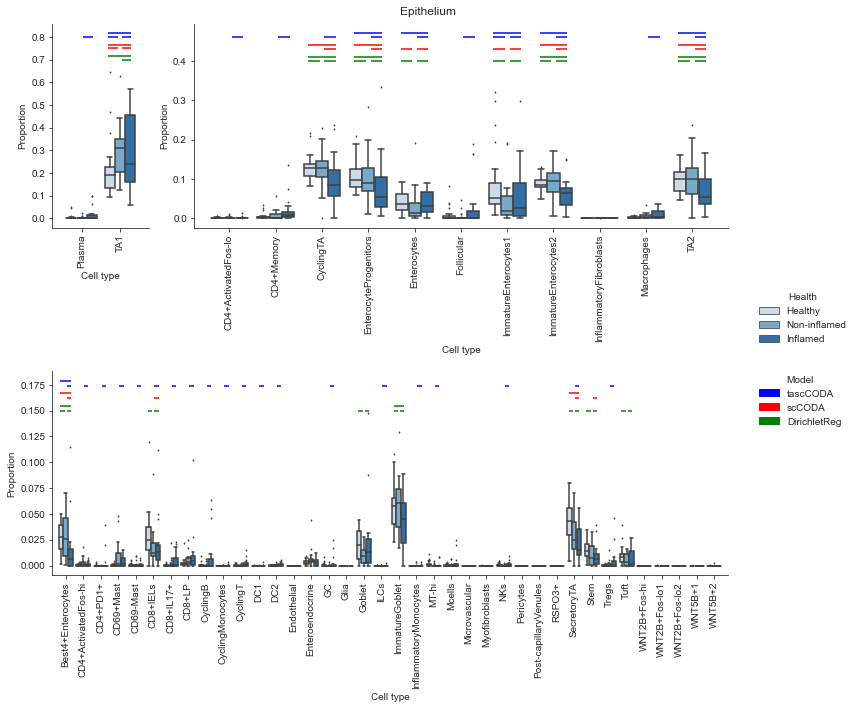

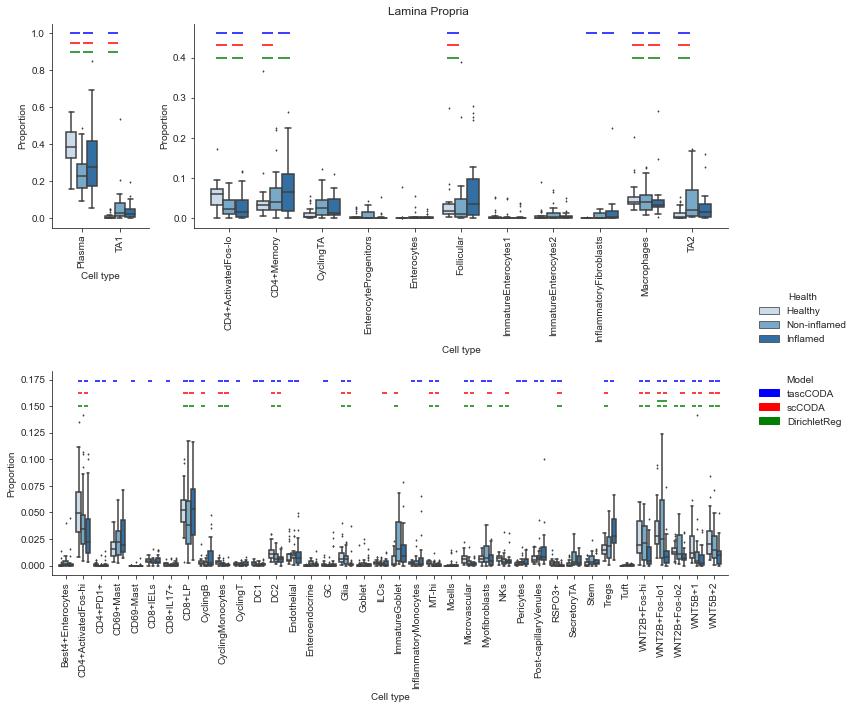

In [30]:
lambda_0 = 50
phi = 1
lambda_1 = 5

results = run_tree_agg(lambda_0, lambda_1, phi, datasets, all_data, 20000, plot=True)


epi_hn

Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_ana.py:110: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)
/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [04:15<00:00, 78.27it/s] 


MCMC sampling finished. (307.048 sec)
Acceptance rate: 88.3%

epi_hi

Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_ana.py:110: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)
/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:43<00:00, 122.62it/s]


MCMC sampling finished. (211.326 sec)
Acceptance rate: 83.9%

epi_ni

Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_ana.py:110: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)
/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:41<00:00, 123.55it/s]


MCMC sampling finished. (208.307 sec)
Acceptance rate: 89.3%

LP_hn

Automatic reference selection! Reference cell type set to NKs
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:59<00:00, 111.21it/s]


MCMC sampling finished. (228.430 sec)
Acceptance rate: 88.0%

LP_hi

Automatic reference selection! Reference cell type set to CD8+IELs
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:09<00:00, 105.49it/s]


MCMC sampling finished. (243.774 sec)
Acceptance rate: 88.7%

LP_ni

Automatic reference selection! Reference cell type set to DC2
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:11<00:00, 104.51it/s]


MCMC sampling finished. (239.936 sec)
Acceptance rate: 87.7%


/Users/johannes.ostner/opt/anaconda3/envs/scCODA_3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


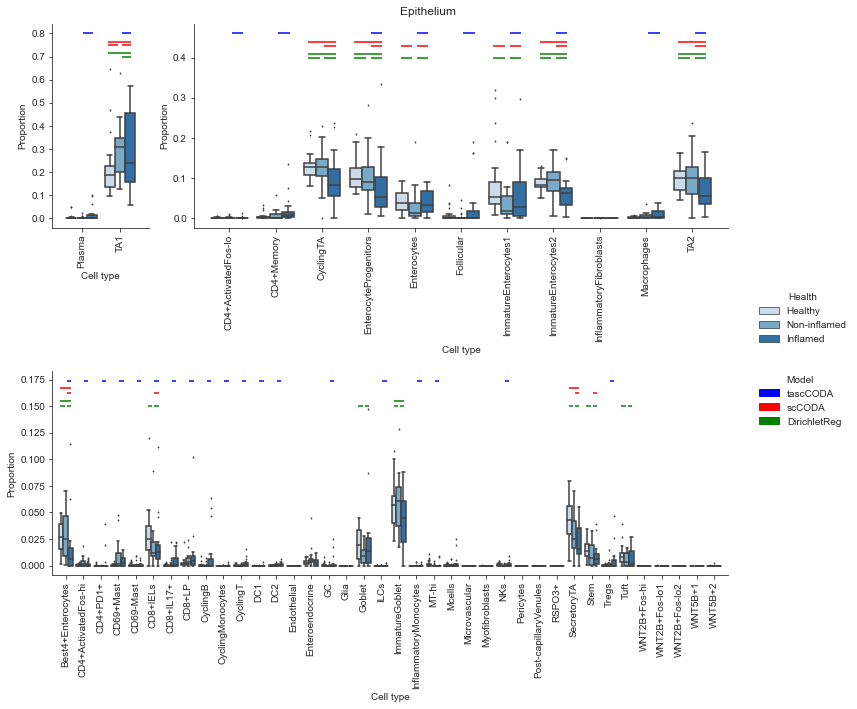

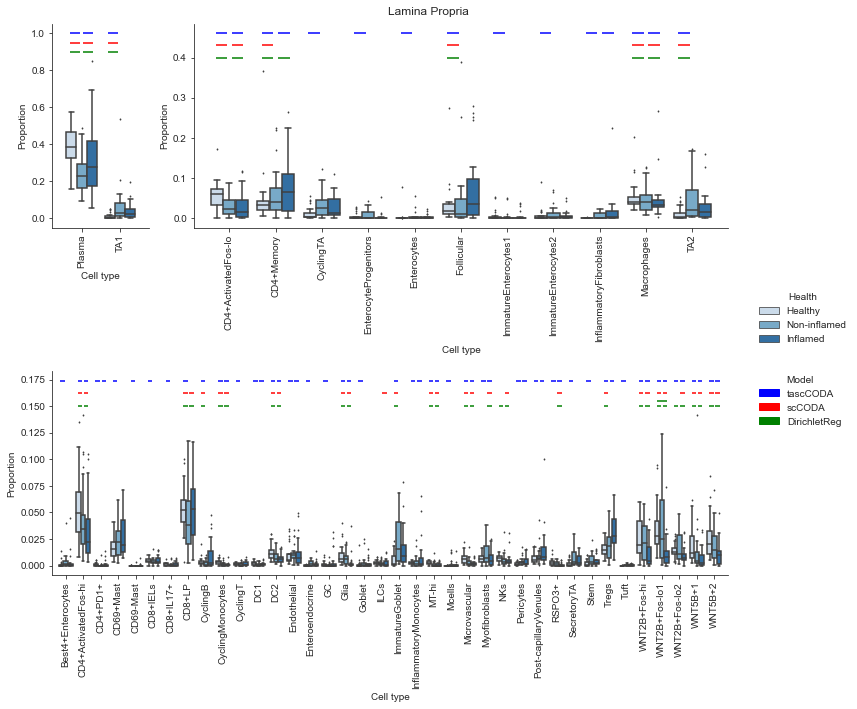

In [31]:
lambda_0 = 50
phi = -1
lambda_1 = 5

results = run_tree_agg(lambda_0, lambda_1, phi, datasets, all_data, 20000, plot=True)


epi_hn

Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_ana.py:110: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)
/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:57<00:00, 112.46it/s]


MCMC sampling finished. (229.780 sec)
Acceptance rate: 86.0%

epi_hi

Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_ana.py:110: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)
/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:51<00:00, 116.48it/s]


MCMC sampling finished. (221.479 sec)
Acceptance rate: 83.9%

epi_ni

Automatic reference selection! Reference cell type set to ImmatureGoblet
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_ana.py:110: RuntimeWarning: invalid value encountered in true_divide
  cell_type_disp = np.var(rel_abun, axis=0)/np.mean(rel_abun, axis=0)
/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:48<00:00, 118.84it/s]


MCMC sampling finished. (217.648 sec)
Acceptance rate: 85.1%

LP_hn

Automatic reference selection! Reference cell type set to NKs
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:28<00:00, 95.86it/s] 


MCMC sampling finished. (263.153 sec)
Acceptance rate: 88.4%

LP_hi

Automatic reference selection! Reference cell type set to CD8+IELs
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:52<00:00, 115.75it/s]


MCMC sampling finished. (224.108 sec)
Acceptance rate: 87.1%

LP_ni

Automatic reference selection! Reference cell type set to DC2
Zero counts encountered in data! Added a pseudocount of 0.5.


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:49<00:00, 117.91it/s]


MCMC sampling finished. (214.908 sec)
Acceptance rate: 86.7%


/Users/johannes.ostner/opt/anaconda3/envs/scCODA_3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


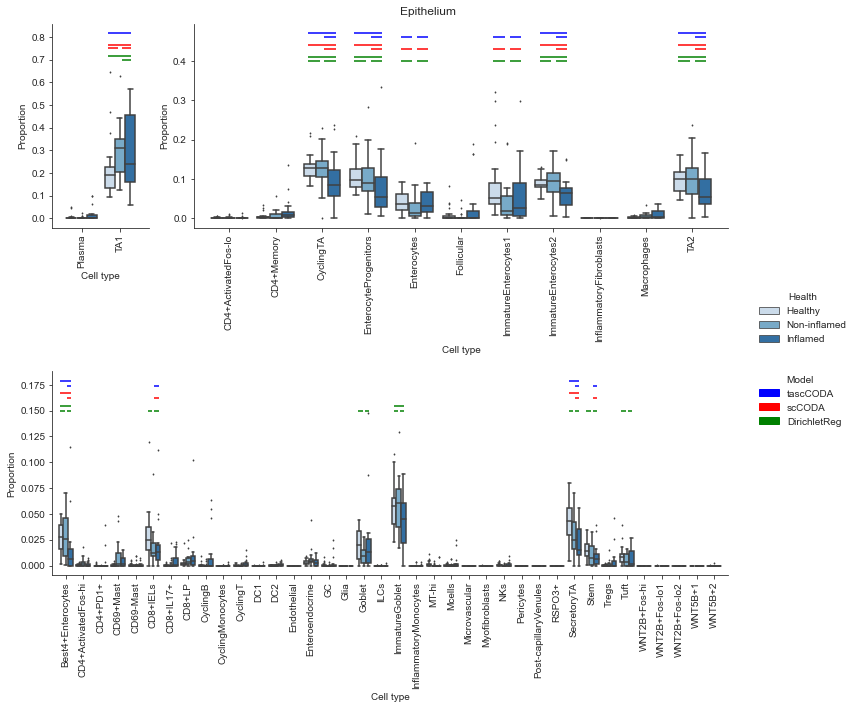

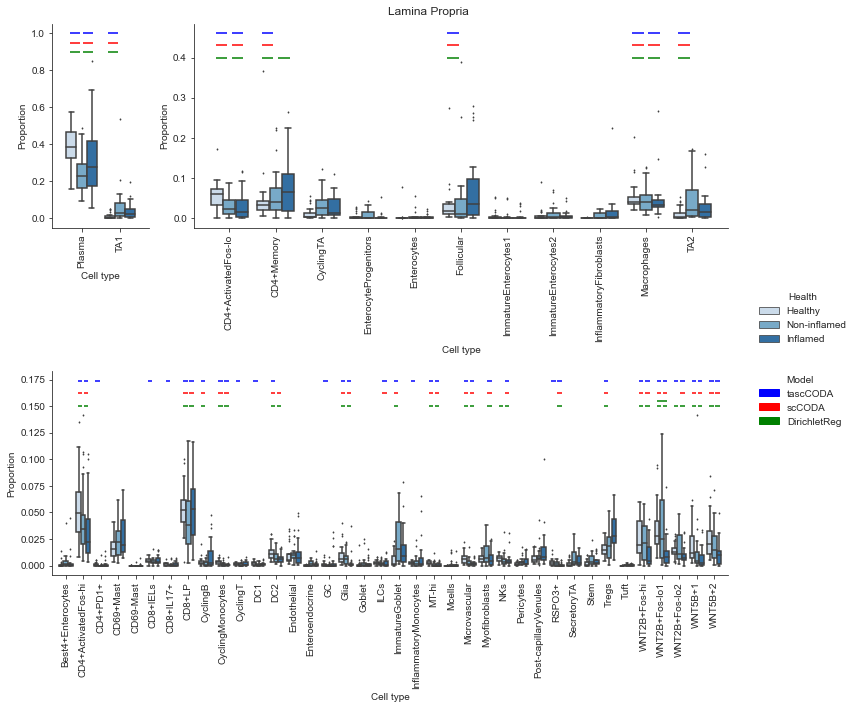

In [32]:
lambda_0 = 50
phi = 10
lambda_1 = 5

results = run_tree_agg(lambda_0, lambda_1, phi, datasets, all_data, 20000, plot=True)

Generate latex for supplementary tables (phi=5 and phi=0)

In [10]:
lambda_0 = 50
phi = 5
lambda_1 = 5
chain_length = 20000

titles = {
    "epi_hn": "Epithelium - H vs. N",
    "epi_hi": "Epithelium - H vs. I",
    "epi_ni": "Epithelium - N vs. I",
    "LP_hn": "LP - H vs. N",
    "LP_hi": "LP - H vs. I",
    "LP_ni": "LP - N vs. I",
}

run_name = f"tree_agg_l0_{lambda_0}_l1_{lambda_1}_phi_{phi}_n_{chain_length}"
result_path="../../../tascCODA_data/applications/smillie_UC"


adf = []
for name in titles.keys():
    node = pd.read_csv(result_path + f"/{run_name}/{name}_nodes")
    node["Scenario"] = titles[name]
    adf.append(node)

In [11]:
adf2 = pd.concat(adf)
adf2 = adf2.set_index("Scenario", append=True)
adf2 = adf2.swaplevel(0, 1)
adf2["Delta"] = np.round(adf2["Delta"], 3)
adf2

Covariate                  Node  \
Scenario                                                                     
Epithelium - H vs. N 0   Health[T.Non-inflamed]_node                Mcells   
                     1   Health[T.Non-inflamed]_node                  Stem   
                     2   Health[T.Non-inflamed]_node             CyclingTA   
                     3   Health[T.Non-inflamed]_node  ImmatureEnterocytes1   
                     4   Health[T.Non-inflamed]_node  ImmatureEnterocytes2   
...                                              ...                   ...   
LP - N vs. I         69  Health[T.Non-inflamed]_node              Lymphoid   
                     70  Health[T.Non-inflamed]_node               Myeloid   
                     71  Health[T.Non-inflamed]_node            Epithelial   
                     72  Health[T.Non-inflamed]_node               Stromal   
                     73  Health[T.Non-inflamed]_node                Immune   

                         Final Parameter  Median  HDI 3%  HDI 97%     SD  \
Scenario                                                                   
Epithelium - H vs. N 0             0.000   0.002  -0.217    0.253  0.112   
                     1             0.000  -0.035  -0.393    0.117  0.139   
                     2             0.000  -0.010  -0.162    0.088  0.063   
                     3            -0.647  -0.647  -0.984   -0.309  0.181   
                     4             0.000  -0.006  -0.194    0.120  0.077   
...                                  ...     ...     ...      ...    ...   
LP - N vs. I         69            0.000  -0.000  -0.028    0.022  0.013   
                     70            0.000   0.000   0.000    0.000  0.000   
                     71            0.000   0.001  -0.025    0.050  0.023   
                     72            0.000   0.003  -0.030    0.092  0.039   
                     73            0.000   0.000   0.000    0.000  0.000   

                         Delta  Is significant  
Scenario                                        
Epithelium - H vs. N 0   0.148           False  
                     1   0.148           False  
                     2   0.148           False  
                     3   0.148            True  
                     4   0.148           False  
...                        ...             ...  
LP - N vs. I         69  0.131           False  
                     70  0.000           False  
                     71  0.132           False  
                     72  0.134           False  
                     73  0.000           False  

[444 rows x 9 columns]

In [32]:
print(adf2.loc[adf2["Final Parameter"] != 0, ["Final Parameter", "HDI 3%", "HDI 97%", "SD", "Delta"]].to_latex())

\begin{tabular}{llrrrrr}
\toprule
             &             &  Final Parameter &  HDI 3\% &  HDI 97\% &     SD &  Delta \\
Scenario & Node &                  &         &          &        &        \\
\midrule
Epithelium - H vs. N & ImmatureEnterocytes1 &           -0.647 &  -0.984 &   -0.309 &  0.181 &  0.148 \\
             & Enterocytes &           -0.211 &  -0.637 &    0.054 &  0.211 &  0.148 \\
             & TA1 &            0.280 &  -0.022 &    0.475 &  0.134 &  0.148 \\
Epithelium - H vs. I & Stem &           -0.518 &  -1.000 &    0.004 &  0.286 &  0.135 \\
             & CyclingTA &           -0.855 &  -1.144 &   -0.592 &  0.146 &  0.135 \\
             & Best4+Enterocytes &           -0.163 &  -0.893 &    0.141 &  0.303 &  0.135 \\
             & TA2 &           -0.229 &  -0.802 &    0.129 &  0.282 &  0.135 \\
             & TA1 &            0.240 &  -0.159 &    0.730 &  0.265 &  0.135 \\
             & SecretoryTA &           -0.889 &  -1.334 &   -0.477 &  0.228 &  0.135 \\


In [12]:
lambda_0 = 50
phi = 0
lambda_1 = 5
chain_length = 20000

titles = {
    "epi_hn": "Epithelium - H vs. N",
    "epi_hi": "Epithelium - H vs. I",
    "epi_ni": "Epithelium - N vs. I",
    "LP_hn": "LP - H vs. N",
    "LP_hi": "LP - H vs. I",
    "LP_ni": "LP - N vs. I",
}

run_name = f"tree_agg_l0_{lambda_0}_l1_{lambda_1}_phi_{phi}_n_{chain_length}"
result_path="../../../tascCODA_data/applications/smillie_UC"


adf = []
for name in titles.keys():
    node = pd.read_csv(result_path + f"/{run_name}/{name}_nodes")
    node["Scenario"] = titles[name]
    adf.append(node)

In [13]:
adf2 = pd.concat(adf)
adf2 = adf2.set_index("Scenario", append=True)
adf2 = adf2.swaplevel(0, 1)
adf2["Delta"] = np.round(adf2["Delta"], 3)
adf2


Covariate                  Node  \
Scenario                                                                     
Epithelium - H vs. N 0   Health[T.Non-inflamed]_node                Mcells   
                     1   Health[T.Non-inflamed]_node                  Stem   
                     2   Health[T.Non-inflamed]_node             CyclingTA   
                     3   Health[T.Non-inflamed]_node  ImmatureEnterocytes1   
                     4   Health[T.Non-inflamed]_node  ImmatureEnterocytes2   
...                                              ...                   ...   
LP - N vs. I         69  Health[T.Non-inflamed]_node              Lymphoid   
                     70  Health[T.Non-inflamed]_node               Myeloid   
                     71  Health[T.Non-inflamed]_node            Epithelial   
                     72  Health[T.Non-inflamed]_node               Stromal   
                     73  Health[T.Non-inflamed]_node                Immune   

                         Final Parameter  Median  HDI 3%  HDI 97%     SD  \
Scenario                                                                   
Epithelium - H vs. N 0               0.0     0.0  -0.006    0.006  0.005   
                     1               0.0    -0.0  -0.007    0.007  0.007   
                     2               0.0     0.0  -0.007    0.006  0.004   
                     3               0.0    -0.0  -0.009    0.006  0.042   
                     4               0.0    -0.0  -0.006    0.005  0.006   
...                                  ...     ...     ...      ...    ...   
LP - N vs. I         69              0.0    -0.0  -0.005    0.004  0.004   
                     70              0.0     0.0   0.000    0.000  0.000   
                     71              0.0     0.0  -0.004    0.005  0.003   
                     72              0.0     0.0  -0.004    0.006  0.008   
                     73              0.0     0.0   0.000    0.000  0.000   

                         Delta  Is significant  
Scenario                                        
Epithelium - H vs. N 0   0.150           False  
                     1   0.150           False  
                     2   0.150           False  
                     3   0.150           False  
                     4   0.150           False  
...                        ...             ...  
LP - N vs. I         69  0.151           False  
                     70  0.000           False  
                     71  0.151           False  
                     72  0.151           False  
                     73  0.000           False  

[444 rows x 9 columns]

In [14]:
print(adf2.loc[adf2["Final Parameter"] != 0, ["Final Parameter", "HDI 3%", "HDI 97%", "SD", "Delta"]].to_latex())


\begin{tabular}{llrrrrr}
\toprule
             &    &  Final Parameter &  HDI 3\% &  HDI 97\% &     SD &  Delta \\
Scenario & {} &                  &         &          &        &        \\
\midrule
Epithelium - H vs. I & 2  &           -0.394 &  -0.669 &    0.010 &  0.193 &  0.074 \\
             & 9  &            0.151 &  -0.023 &    0.496 &  0.176 &  0.074 \\
             & 54 &           -0.117 &  -0.500 &    0.026 &  0.177 &  0.074 \\
             & 65 &           -0.553 &  -0.853 &   -0.205 &  0.179 &  0.074 \\
             & 73 &            0.149 &  -0.015 &    0.324 &  0.108 &  0.074 \\
LP - H vs. N & 40 &           -0.086 &  -0.524 &    0.037 &  0.185 &  0.066 \\
             & 61 &           -0.612 &  -0.796 &   -0.425 &  0.100 &  0.066 \\
             & 62 &           -0.761 &  -1.011 &   -0.380 &  0.173 &  0.066 \\
             & 63 &           -0.315 &  -0.618 &    0.024 &  0.216 &  0.066 \\
             & 70 &           -0.113 &  -0.511 &    0.035 &  0.184 &  0.066 \\
   